In [1]:
# from the testing.csv, plot a bar chart showing the number of occurances of each patientID (given that we have from 001 to 369)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp


Kolmogorov-Smirnov (K-S) test, a statistical test used to compare a sample of data with a reference probability distribution or to compare two samples

- D statistic: maximum vertical distance between the two cumulative distribution functions (CDFs) you are comparing.

    A value of 0 would mean the two distributions are identical.

    A value closer to 1 would mean they are completely different.


- p-value: represents the probability of obtaining a result at least as extreme as the one you observed, assuming that the two distributions are actually identical (this is the "null hypothesis"). 

    Null Hypothesis: The two samples are drawn from the same distribution.
    
    p-value < 0.05: Reject H_{0}. The samples likely come from different distributions.
    
    p-value >= 0.05: Fail to reject H_{0}. The samples could come from the same distribution.
    
- statistic_location: This is the value in dataset (on the x-axis) where the maximum difference (the D statistic) occurred.

- statistic_sign: This indicates the direction of the difference at the statistic_location.

    1 means that at the point x=46, the empirical CDF of your sample was greater than the CDF of the reference distribution.

    -1 would mean your sample's CDF was less than the reference CDF.

    Interpretation: This helps you understand the nature of the discrepancy. For example, it might tell you that your sample has more data points below 46 than the reference distribution would predict.



In [3]:
train = pd.read_csv("set_training.csv")
test = pd.read_csv("set_testing.csv")

# basic distribution of patients and slices
train_patient_counts = train["Patient"].value_counts().sort_index()
test_patient_counts = test["Patient"].value_counts().sort_index()

train_slice_dist = train["SliceIndex"].values
test_slice_dist = test["SliceIndex"].values


# Tumor size + centroid extraction

In [19]:
import os
def extract_slice_stats(df, folder):
    tumor_sizes = []
    centroids = []
    for _, row in df.iterrows():
        pid = int(row["Patient"])
        sidx = int(row["SliceIndex"])

        mask_path = os.path.join(folder, f"{pid:03d}_{sidx}_mask.npy")
        if not os.path.exists(mask_path):
            print(f"Warning: mask file {mask_path} does not exist.")
            continue

        mask = np.load(mask_path)

        # tumor size
        size = np.sum(mask > 0)
        tumor_sizes.append(size)

        if size > 0:
            coords = np.argwhere(mask > 0)
            cy = coords[:,0].mean() / mask.shape[0]  # normalized
            cx = coords[:,1].mean() / mask.shape[1]  # normalized
            centroids.append([cx, cy])

    return np.array(tumor_sizes), np.array(centroids)

train_sizes, train_centroids = extract_slice_stats(train, "training_set_npy")
test_sizes, test_centroids = extract_slice_stats(test, "testing_set_npy")


# Patient coverage

In [20]:
used_train = (train_patient_counts > 0).sum()
used_test  = (test_patient_counts > 0).sum()

print("Patient coverage:")
print(f"Train: {used_train} ({used_train/369*100:.2f}%)")
print(f"Test : {used_test} ({used_test/369*100:.2f}%)")


Patient coverage:
Train: 30 (8.13%)
Test : 97 (26.29%)


In [28]:
ks_slice = ks_2samp(train_slice_dist, test_slice_dist)
print("Slice index KS:", ks_slice)
ks_size = ks_2samp(train_sizes, test_sizes)
print("Tumor size KS:", ks_size)
ks_x = ks_2samp(train_centroids[:,0], test_centroids[:,0])
ks_y = ks_2samp(train_centroids[:,1], test_centroids[:,1])
print("Centroid X KS:", ks_x)
print("Centroid Y KS:", ks_y)



Slice index KS: KstestResult(statistic=0.11333333333333333, pvalue=0.8969029848891695, statistic_location=46, statistic_sign=1)
Tumor size KS: KstestResult(statistic=0.20666666666666667, pvalue=0.24426693896019372, statistic_location=3435, statistic_sign=-1)
Centroid X KS: KstestResult(statistic=0.09333333333333334, pvalue=0.9767129625601708, statistic_location=0.5244469394544244, statistic_sign=1)
Centroid Y KS: KstestResult(statistic=0.20666666666666667, pvalue=0.24426693896019372, statistic_location=0.5684305346070052, statistic_sign=1)


# Plot

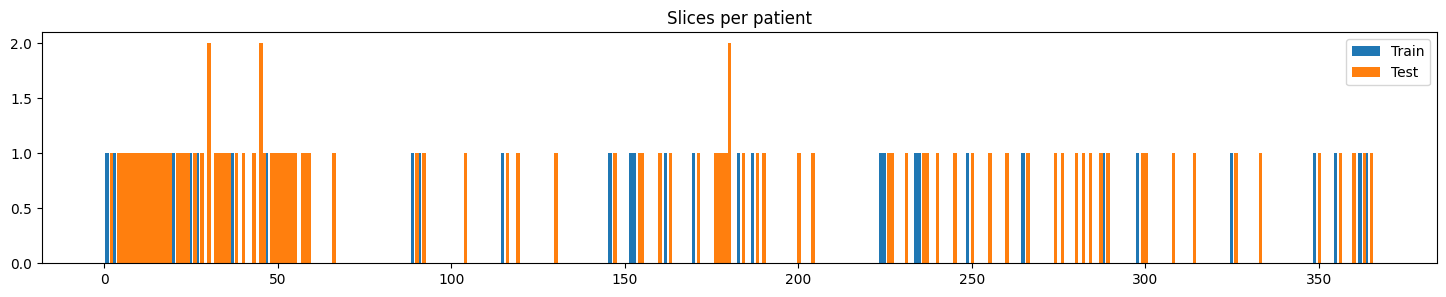

In [24]:
plt.figure(figsize=(18,3))
plt.bar(train_patient_counts.index - 0.2, train_patient_counts.values, width=1, label="Train")
plt.bar(test_patient_counts.index + 0.2, test_patient_counts.values, width=1, label="Test")
plt.legend()
plt.title("Slices per patient")
plt.show()


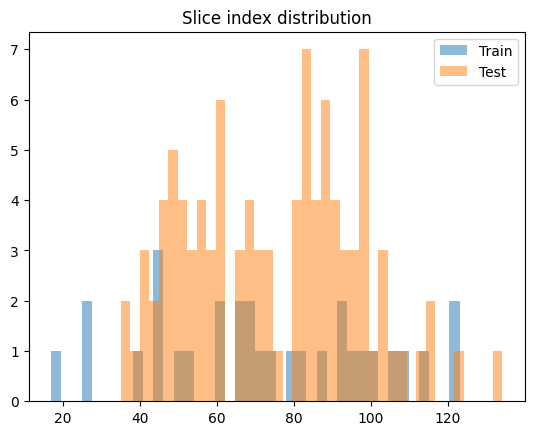

In [25]:
plt.hist(train_slice_dist, bins=40, alpha=0.5, label="Train")
plt.hist(test_slice_dist, bins=40, alpha=0.5, label="Test")
plt.legend()
plt.title("Slice index distribution")
plt.show()


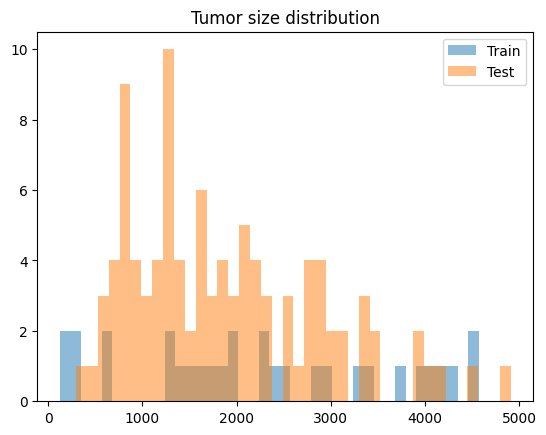

In [26]:
plt.hist(train_sizes, bins=40, alpha=0.5, label="Train")
plt.hist(test_sizes, bins=40, alpha=0.5, label="Test")
plt.legend()
plt.title("Tumor size distribution")
plt.show()


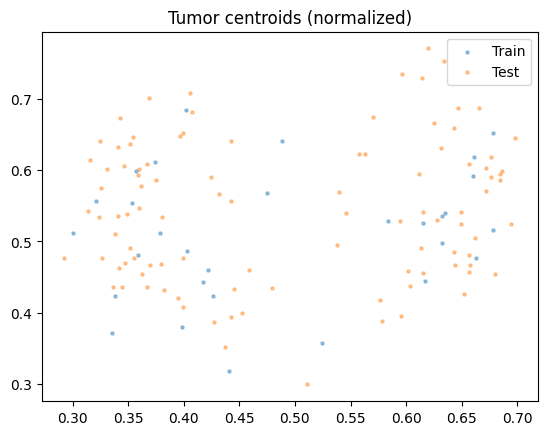

In [27]:
plt.scatter(train_centroids[:,0], train_centroids[:,1], s=5, alpha=0.4, label="Train")
plt.scatter(test_centroids[:,0], test_centroids[:,1], s=5, alpha=0.4, label="Test")
plt.legend()
plt.title("Tumor centroids (normalized)")
plt.show()


training and test sets are very well-matched. For all four features tested, there is no statistically significant difference between the distributions in training and test sets.

Tumor size: With a p-value of 0.244, this is still well above the common significance threshold of 0.05. We do not have enough evidence to say the training and test sets have different tumor size distributions.
the largest divergence among features (D=0.207) - the test set might have a slightly higher concentration of tumors around this size.


X Coordinate: The p-value of 0.977 is almost perfect, indicating no meaningful difference in the X-axis distribution.

Y Coordinate: The p-value of 0.244 is identical to the tumor size result (this is likely a coincidence but confirms the pattern). It suggests no significant difference, though it's the same feature that shows the most noticeable (but still not significant) divergence.